# Attention Mechanisms and Transformers:
While not RNNs in the traditional sense, attention mechanisms and transformer models have largely replaced RNNs in many applications. They allow the model to focus on different parts of the input sequence when making predictions, which can be more effective for tasks like machine translation and text summarization.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


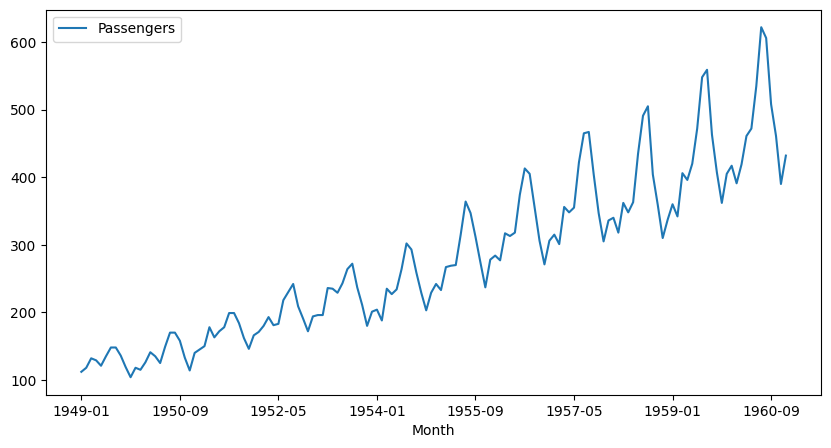

In [ ]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url)

# Visualize the data
print(data.head())
data.plot(x='Month', y='Passengers', figsize=(10, 5))
plt.show()

# Preprocess the data

In [ ]:
# Datetime fprmating
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Select features and target
features = ['Passengers']
target = 'Passengers'

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
target_scaler = MinMaxScaler()
data[target] = target_scaler.fit_transform(data[[target]])

# Convert to numpy arrays
X = data[features].values
y = data[target].values

# Create sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Transformer model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/100], Loss: 0.1463
Epoch [20/100], Loss: 0.0707
Epoch [30/100], Loss: 0.0566
Epoch [40/100], Loss: 0.0495
Epoch [50/100], Loss: 0.0471
Epoch [60/100], Loss: 0.0266
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0154


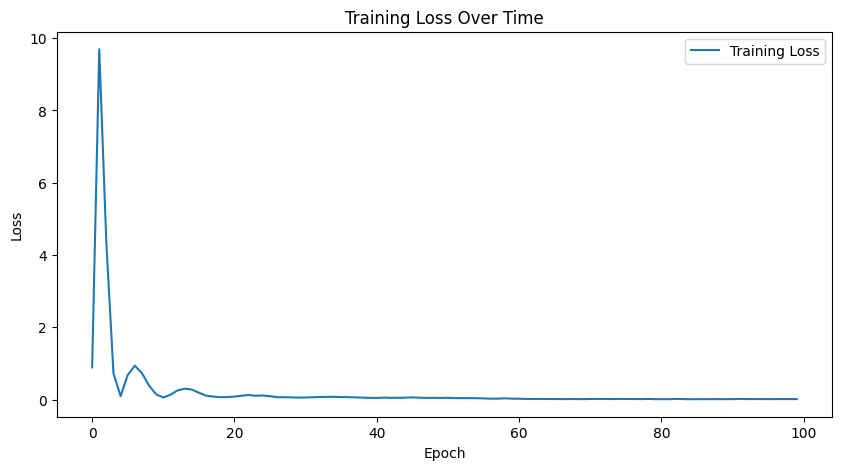

In [ ]:
# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_heads = num_heads

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

        self.input_fc = nn.Linear(input_size, hidden_size)
        self.positional_encoding = self._generate_positional_encoding(seq_length, hidden_size)

    def forward(self, x):
        x = self.input_fc(x) + self.positional_encoding
        x = x.permute(1, 0, 2)  # Transformer expects input shape (seq_len, batch_size, hidden_size)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Convert back to (batch_size, seq_len, hidden_size)
        x = self.fc(x[:, -1, :])  # Use the output of the last time step
        return x

    def _generate_positional_encoding(self, seq_length, hidden_size):
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-np.log(10000.0) / hidden_size))
        pe = torch.zeros(seq_length, hidden_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

# Hyperparameters
input_size = len(features)
hidden_size = 64
output_size = 1
num_layers = 2
num_heads = 4
num_epochs = 100
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_heads)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Evaluate the model

Test Loss: 0.0038


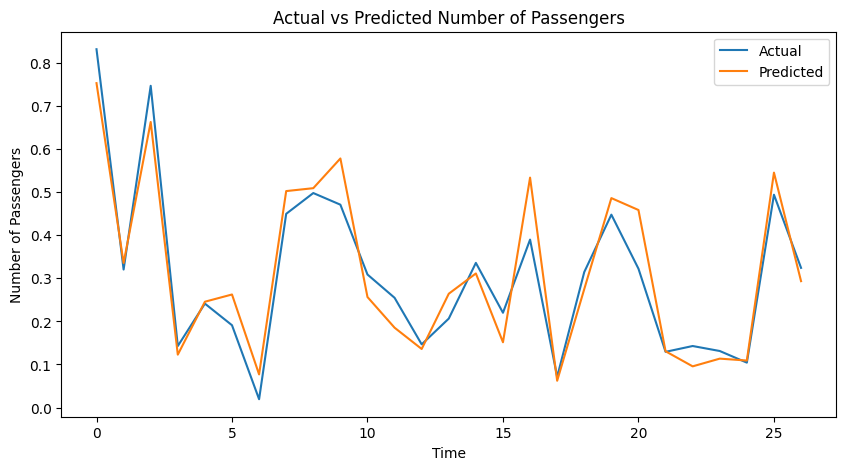

Mean Absolute Percentage Error (MAPE): 26.56%


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform the predictions and actual values
y_test_inv = target_scaler.inverse_transform(y_test.numpy())
test_outputs_inv = target_scaler.inverse_transform(test_outputs.numpy())

# Visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_outputs_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.title('Actual vs Predicted Number of Passengers')
plt.legend()
plt.show()

# Calculate accuracy (e.g., Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_inv, test_outputs_inv)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# If you want to save the model

In [ ]:
torch.save(model.state_dict(), 'transformer_airline_passengers.pth')

# Full code

In [ ]:
# Load the data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url)

# Visualize the data
print(data.head())
data.plot(x='Month', y='Passengers', figsize=(10, 5))
plt.show()

# Preprocess the data
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Select features and target
features = ['Passengers']
target = 'Passengers'

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
target_scaler = MinMaxScaler()
data[target] = target_scaler.fit_transform(data[[target]])

# Convert to numpy arrays
X = data[features].values
y = data[target].values

# Create sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_heads = num_heads

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

        self.input_fc = nn.Linear(input_size, hidden_size)
        self.positional_encoding = self._generate_positional_encoding(seq_length, hidden_size)

    def forward(self, x):
        x = self.input_fc(x) + self.positional_encoding
        x = x.permute(1, 0, 2)  # Transformer expects input shape (seq_len, batch_size, hidden_size)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Convert back to (batch_size, seq_len, hidden_size)
        x = self.fc(x[:, -1, :])  # Use the output of the last time step
        return x

    def _generate_positional_encoding(self, seq_length, hidden_size):
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-np.log(10000.0) / hidden_size))
        pe = torch.zeros(seq_length, hidden_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

# Hyperparameters
input_size = len(features)
hidden_size = 64
output_size = 1
num_layers = 2
num_heads = 4
num_epochs = 100
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_heads)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_lossestrain_losses = []
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform the predictions and actual values
y_test_inv = target_scaler.inverse_transform(y_test.numpy())
test_outputs_inv = target_scaler.inverse_transform(test_outputs.numpy())

# Visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_outputs_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.title('Actual vs Predicted Number of Passengers')
plt.legend()
plt.show()

# Calculate accuracy (e.g., Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_inv, test_outputs_inv)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# If you want to save the model
torch.save(model.state_dict(), 'transformer_airline_passengers.pth')